In [32]:
# --- Simple Deep Learning Model using Keras ---

# install dependencies
!pip install -q scikeras

# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf



In [33]:
# Set random seed for reproduciblity
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [34]:
#-------------#
# Data Loading
#-------------#

# uploading Kaggle API key
from google.colab import files
files.upload()

# Configure Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Downloading and unzip Kaggle's Data

!kaggle competitions download -c house-prices-advanced-regression-techniques
!unzip house-prices-advanced-regression-techniques.zip

# Loading training Data
data = pd.read_csv('train.csv')
print("Training Data is loaded successfully. Shape:", data.shape)
data.head()

Saving kaggle.json to kaggle.json
house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  house-prices-advanced-regression-techniques.zip
replace data_description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data_description.txt    
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               
Training Data is loaded successfully. Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [44]:
#-------------------#
# Data Preprocessing
#-------------------#

# Keep only numeric columns
numerical_data= data.select_dtypes(include=['int64','float64']).copy()

# Drop 'Id' column which is not useful for training
numerical_data.drop(columns='Id', inplace=True,errors='ignore')

# Fill missing numeric values with the column means
numerical_data = numerical_data.fillna(numerical_data.mean())


# Splitting the data into input features (X) and target values (y)
X = numerical_data.drop(columns='SalePrice', axis=1)
y = numerical_data['SalePrice']


# Making manual Standard Scaler (mean = 0, std = 1) for the feature to make the values centered around 0
#X_scaled = (X - X.mean()) / X.std()

# log-transform the target to stabilize variance
y_log = np.log1p(y)

# Split into training and validation sets
X_train_raw, Xval_raw, y_train, yval = train_test_split(
    X, y_log , test_size=0.2, random_state=SEED)

train_mean = X_train_raw.mean()
train_std  = X_train_raw.std()

X_train = (X_train_raw - train_mean) / train_std
X_val   = (Xval_raw - train_mean) / train_std

print("Data preprocessing complete.")



Data preprocessing complete.


In [36]:
#-------------------#
# Model Definition
#-------------------#

model = Sequential(
  [
      Dense(128, activation='relu', input_shape=(X_train.shape[1],)), #specifies number of features per sample
      Dropout(0.2),# sets 20% of the prev layer neurons to zero during training (to decrease overfitting),
      Dense(64, activation='relu'),
      #Dropout(0.2),
      Dense(1) # Regression output (no activation because raw value needed)
  ]
)

from tensorflow.keras.optimizers import Adam

initial_lr = 1e-3
model.compile(
    optimizer=Adam(learning_rate=initial_lr),  # Adaptive optimizer
    loss='mse',        # Mean Squared Error (for regression)
    metrics=['mae']    # Mean Absolute Error as performance metric
)

model.summary()




/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 13,057 (51.00 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
#---------------#
# Model Training
#---------------#

# Adding callbacks to improve training

# saves training time by stopping when no further improvement happens (prevent overfitting)
early_stop = EarlyStopping(
    monitor='val_loss',       # metric to watch
    patience=10,              # wait 10 epochs without improvement
    restore_best_weights=True # restore model to best epoch
)
# Lowering learning rate when progress stalls for finer optimization
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-5  # prevent it from going too low
)

# Train model
history = model.fit(
    X_train, y_train,
    epochs= 500,
    batch_size=32, # number of samples processed before the model updates weights , no of batch in each epoch = no of samples/ batch size
    validation_data=(X_val, yval),
    callbacks=[early_stop, reduce_lr],
    verbose=1 # to show progress bar (logging output)
)



Epoch 1/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 107.5948 - mae: 10.1588 - val_loss: 17.7265 - val_mae: 3.7157 - learning_rate: 0.0010
Epoch 2/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 15.7623 - mae: 3.0770 - val_loss: 6.0668 - val_mae: 1.9922 - learning_rate: 0.0010
Epoch 3/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.9426 - mae: 2.0000 - val_loss: 3.4727 - val_mae: 1.4799 - learning_rate: 0.0010
Epoch 4/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3946 - mae: 1.5908 - val_loss: 2.5288 - val_mae: 1.2629 - learning_rate: 0.0010
Epoch 5/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.8577 - mae: 1.4987 - val_loss: 2.2033 - val_mae: 1.1869 - learning_rate: 0.0010
Epoch 6/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.4344 - mae: 1.4117 - val_loss: 2.0682 - val_mae: 1.1277 - learning_rate: 0.0010
Epoch 7/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.2099 - mae: 1.3647 - val_loss: 1.9375 - val_mae: 1.0908 - learning_rate: 0.0010
E


 Validation MAE (log scale): 0.1036
≈ 10.91% average relative error in price prediction
Final Training MAE: 0.1150
Final Validation MAE: 0.1105


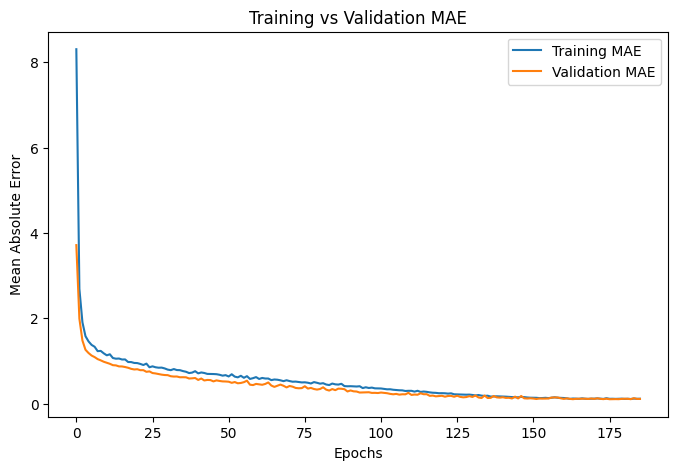

In [38]:
#-------------------#
# Model Evaluation
#-------------------#


# Evaluate model performamce on validation set
loss, mae= model.evaluate(X_val, yval, verbose=0)
print(f"\n Validation MAE (log scale): {mae:.4f}")
print(f"≈ {np.expm1(mae):.2%} average relative error in price prediction")

# Compare last training and validation MAE
print(f"Final Training MAE: {history.history['mae'][-1]:.4f}")
print(f"Final Validation MAE: {history.history['val_mae'][-1]:.4f}")

# Plot training vs validation MAE
plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training vs Validation MAE')
plt.legend()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


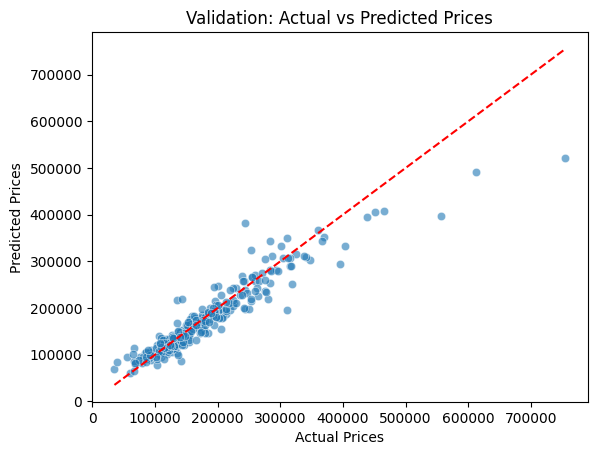

In [39]:
#-----------------------#
# Validation Predictions
#-----------------------#

# Convert log predictions back to real prices
y_pred_val = np.expm1(model.predict(X_val)) # reverse log transform
y_true_val = np.expm1(yval)
# flattens multi-dimensional arrays into 1D arrays.
y_true_val = np.ravel(y_true_val)  # or .flatten()
y_pred_val = np.ravel(y_pred_val)
# scatter plot of predictions vs true values
sns.scatterplot(x=y_true_val, y=y_pred_val, alpha=0.6)
# Drawing red dashed line
plt.plot([y_true_val.min(), y_true_val.max()],
         [y_true_val.min(),y_true_val.max()], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Validation: Actual vs Predicted Prices')
plt.show()


In [40]:
#-----------------------#
# Test Data Preperation
#-----------------------#

test = pd.read_csv('test.csv')

# using only numeric columns like in training
test_num = test.select_dtypes(include=['int64','float64']).copy()

# Drop 'ID' if exists
test_num.drop(columns=['Id'], inplace=True,errors='ignore')

# Fill missing numeric values using training mean
test_num = test_num.fillna(train_mean)

# Standardize features using training mean & std
test_scaled = (test_num[X_train_raw.columns] - train_mean) / train_std



In [41]:
# --------------------- #
# Final Test Predictions
# --------------------- #

# The output will be logged because the model is trained in this way
test_pred_log = model.predict(test_scaled)
test_pred = np.expm1(test_pred_log) # log reverse to get real prices

submission = pd.DataFrame({
    "Id": test['Id'],
    "SalePrice":test_pred.flatten()

})

submission.to_csv("submission.csv", index=False)
print("submission.csv created successfully")
submission.head()

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
submission.csv created successfully


,Id,SalePrice
0,1461,121173.109375
1,1462,94457.101562
2,1463,184150.687500
3,1464,194730.250000
4,1465,162997.343750


In [42]:
from google.colab import files
files.download("submission.csv")
print(submission.shape)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(1459, 2)


In [43]:
from google.colab import files
model.save('house_price_model.h5')
files.download('house_price_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>